In [3]:
params_notebook_name = "parnet.embeddings.py.ipynb"
params_resource_dir = "../resources/"
params_subset_chroms = ["chr19", "chr11", "chr14"]

params_subset_rbp_cl = [
    "QKI_HepG2",
    "QKI_K562",
    "PTBP1_HepG2",
    "SRSF7_HepG2",
]

# PARNET - Embeddings

## Overview

Demonstration of how to use the embeddings produced by PARNET to explore the properties
of genomic regions.

Example of applications:

- [ ] Embeddings of genes 
    - clustering on gene-type
    - coloring by gene expression or gene length or sequence content.

- [ ] Embeddings of peaks
    - Assess clustering.
    - coloring on RBP identify, RBP binding domain, sequence content, expression level at peak.

## Imports

In [4]:
import dataclasses
import datetime
import gzip
import inspect
import os
import random
import sys
import tempfile
from dataclasses import asdict
from io import StringIO
from numbers import Number
from pathlib import Path
from typing import Literal, Optional

import Bio.SeqUtils
import more_itertools
import numpy as np
import pandas as pd
import parnet
import parnet.additional_utils
import parnet.utils
import pybedtools as pbt
import pyBigWig as pbw
import pydantic.dataclasses
import pyfaidx
import requests
import torch
import umap
import yaml
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from dotenv import find_dotenv, load_dotenv
from dotmap import DotMap
from IPython.display import HTML, SVG, Image, display
from pydantic.dataclasses import dataclass
from sklearn.decomposition import PCA
from snakemake.io import glob_wildcards

/home/l10n/projects/ml4rg25-parnet/parnet_demo/.pixi/envs/parnet-demo-gpu/lib/python3.10/site-packages/gin/config.py:615: FutureWarning: `NLLLoss2d` has been deprecated. Please use `NLLLoss` instead as a drop-in replacement and see https://pytorch.org/docs/main/nn.html#torch.nn.NLLLoss for more details.
  decorated_class = decorating_meta(cls.__name__, (cls,), overrides)
Seed set to 42
2025-06-24 08:16:01.477064: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 08:16:01.486314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 08:16:01.497811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to regi

In [5]:
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

try:
    matplotlib.font_manager.findfont("Arial")
    mpl.rcParams["font.sans-serif"] = ["Arial"]
except Exception as e:
    print("Setting Arial font failed in some way...")
    print(e)

rc("text", usetex=False)

In [6]:
def assert_notebook_working_dir(expected_local_file: os.PathLike) -> Path:
    """Assert or try updating the current working directory to where the notebook is located, to enable relative paths references.

    This function is used in a set-up where notebooks are contained within a project
    directory structure in which we want to reference filepaths relative to the notebook.
    e.g. "../src" or "../resources" should be accessible if the notebook is in
    "../notebooks/<notebook_name>.ipynb".

    The function first check the filepath of the expected local file relative
    to the current working directory.

    If not found, the function will try to use the VSCode Jupyter variable `__vsc_ipynb_file__`
    which should report the path of the notebook file being executed.

    It then checks if the expected local file exists, relative to the new working directory.


    Args:
        expected_local_file (os.PathLike): The expected local file to check for in the current working directory.
            This can be the name of the notebook file.

    Raises:
        KeyError: if the `__vsc_ipynb_file__` variable is not found in the global scope, while the first CWD check failed.
        FileNotFoundError: if the expected local file is not found in the current working directory after attempting to change it.
    """
    import os
    from pathlib import Path

    cwd = Path(os.getcwd())
    expected_local_filepath = cwd / expected_local_file

    if not expected_local_filepath.exists():
        if "__vsc_ipynb_file__" not in globals():
            raise KeyError(
                f"Detected CWD: {cwd} ; CWD does not contain expected file, but cannot use __vsc_ipynb_file__ to recover."
            )
        else:
            os.chdir(Path(globals()["__vsc_ipynb_file__"]).parent)
            cwd = Path(os.getcwd())
            print(f"Changed CWD to {cwd}")

            expected_local_filepath = cwd / expected_local_file
            if not expected_local_filepath.exists():
                raise FileNotFoundError(
                    f"Updated (using __vsc_ipynb_file__) CWD: {cwd} ; CWD does not contain expected file."
                )

            return cwd
    else:
        print(f"Confirmed CWD: {cwd} contains expected file: {expected_local_file}")
        return cwd


expected_local_file: str = params_notebook_name
cwd = assert_notebook_working_dir(expected_local_file=expected_local_file)
print(cwd)

Confirmed CWD: /home/l10n/projects/ml4rg25-parnet/parnet_demo/notebooks contains expected file: parnet.embeddings.py.ipynb
/home/l10n/projects/ml4rg25-parnet/parnet_demo/notebooks


## Initialization

In [7]:
# Env variables, defined in the `.env` file at the root of the project directory.
load_dotenv(find_dotenv(), override=True)

False

In [8]:
resource_dir = Path(params_resource_dir)
if not resource_dir.exists():
    raise FileNotFoundError("Resource directory does not exist: " + str(resource_dir))

print("Using resources from:", resource_dir)

Using resources from: ../resources


In [9]:
bed6_cols = ["chrom", "start", "end", "name", "score", "strand"]

In [10]:
# Caution: pyBedTools relies on tmp dir, which can get quite large.
def create_randomized_tmp_dir(parent_dir: os.PathLike | None = None) -> str:
    # Get the parent tmp dir where to create a randomized tmp dir.

    parent_tmp_dir = None

    # Default system value
    parent_tmp_dir = Path(tempfile.gettempdir())
    if parent_dir is not None:
        parent_tmp_dir = Path(parent_dir)

    if os.getenv("TMP_DIR") is not None:
        parent_tmp_dir = Path(os.getenv("TMP_DIR"))

    if os.getenv("TMP") is not None:
        parent_tmp_dir = Path(os.getenv("TMP"))

    if parent_tmp_dir is None:
        raise ValueError("No temporary directory specified or found.")

    # Test write access to the parent tmp dir
    if not parent_tmp_dir.is_dir():
        raise NotADirectoryError(f"Parent tmp dir is not a directory: {parent_tmp_dir}")

    if not os.access(parent_tmp_dir, os.W_OK):
        raise PermissionError(f"Parent tmp dir is not writable: {parent_tmp_dir}")

    # Make a randomized tmp dir
    tmp_dir = tempfile.mkdtemp(dir=parent_tmp_dir)
    return tmp_dir


tmp_dir = create_randomized_tmp_dir()
print("Using temporary directory for pyBedTools:", tmp_dir)

pbt.set_tempdir(tmp_dir)

Using temporary directory for pyBedTools: /tmp/tmpjeyfuy13


## Load

### Model

In [11]:
with open(resource_dir / "parnet_models" / "config.parnet_models.yaml") as f:
    config_models = yaml.safe_load(f)

display(config_models["models"])

{'parnet_21m': {'blob_metadata': '21M parameters, 2024-11-26',
  'is_old_model': True,
  'is_penalized': False,
  'identifier_model_weights': 'parnet.21m-none',
  'identifier_table_of_tasks': 'full_rbp_set'},
 'parnet_7m_p0.0': {'blob_metadata': 'penalized model, 7M parameters, 2025-01-10 ; official Github distribution parnet v0.3.0',
  'is_old_model': False,
  'is_penalized': True,
  'penalty': 0.0,
  'softmax_output': ['total', 'target', 'control'],
  'identifier_model_weights': 'parnet.7m-0.0',
  'identifier_table_of_tasks': 'full_rbp_set'},
 'parnet_7m_p2.5': {'blob_metadata': 'penalized model, 7M parameters, penalty of 2.5, 2025-01-10',
  'is_old_model': False,
  'is_penalized': True,
  'penalty': 2.5,
  'softmax_output': ['total', 'target', 'control'],
  'path_model_weights': 'parnet.7m-p2.5',
  'path_table_of_tasks': 'full_rbp_set'}}

In [12]:
filepaths = {
    "parnet.21m-none": resource_dir / "parnet_models" / "parnet.21m-non.pt",
    "parnet.7m-0.0": resource_dir / "parnet_models" / "parnet.7m-0.0.pt",
    "parnet.7m-2.5": resource_dir / "parnet_models" / "parnet.7m-2.5.pt",
    "full_rbp_set": resource_dir / "parnet_models" / "full_rbp_set.tsv",
}

In [13]:
selected_parnet_model = "parnet_7m_p0.0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16
filepath_selected_model = filepaths[config_models["models"][selected_parnet_model]["identifier_model_weights"]]

parnet_model = parnet.additional_utils.load_parnet_model_for_prediction(
    model_weigth_path=filepath_selected_model,
    device=device,
    dtype=dtype,
    is_old_model=config_models["models"][selected_parnet_model]["is_old_model"],
)

parnet.additional_utils.print_basic_info_parnet_model(
    model=parnet_model,
    device=device,
    dtype=dtype,
)

Number of trainable parameters: 7_534_815
Available output data:  dict_keys(['target', 'control', 'total', 'mix_coeff', 'penalty_loss'])


/home/l10n/projects/ml4rg25-parnet/parnet_demo/.pixi/envs/parnet-demo-gpu/lib/python3.10/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


In [14]:
# NOTE: the parnet model is composed of three parts: `stem`, `body`, and `head`.
# We can create a model that produces the embedding vectors by omitting the `head` part.

parnet_model_embedding = torch.nn.Sequential(*[parnet_model.stem, parnet_model.body])
parnet_model_embedding = parnet_model_embedding.to(device=device, dtype=dtype)


### Genome

In [15]:
genome_size_filepath = resource_dir / "general" / "genome" / "hg38.chrom.sizes"
print('Loading the "genome file" from:', genome_size_filepath)

genome_file = pd.read_csv(genome_size_filepath, header=None, sep="\t")
genome_file.columns = ["chrom", "size"]

main_autosomes = [f"chr{i}" for i in range(1, 23)]
sex_chromosomes = ["chrX", "chrY"]
mitochondrial_chromosome = ["chrM"]
main_chromosomes = list(set(main_autosomes) | set(sex_chromosomes) | set(mitochondrial_chromosome))


Loading the "genome file" from: ../resources/general/genome/hg38.chrom.sizes


In [16]:
# We also load the genome FASTA file, to demonstrate basic sequence enrichment analysis.
genome_fa_filepath = resource_dir / "general" / "genome" / "hg38.fa"
fa = pyfaidx.Fasta(str(genome_fa_filepath), indexname=str(genome_fa_filepath) + ".fai")

### Gene annotations

#### Metadata from GENCODE

In [ ]:
filepath = resource_dir / "general" / "gene_annotations.hg38.gencode_v40" / "gene_metadata.tsv.gz"
genes_metadata = pd.read_csv(filepath, sep="\t", compression="gzip")

#### Protein coding transcripts - from MANE

In [17]:
pc_mane_bed_filepath = (
    resource_dir / "general" / "gene_annotations.hg38.MANE_v1.4" / "MANE.GRCh38.v1.4.ensembl_genomic.transcripts.bed.gz"
)

# Rather than load the file, we will query it with bedtools,
bt_transcripts = pbt.BedTool(pc_mane_bed_filepath)
bt_transcripts = bt_transcripts.tabix()

bt_genome = pbt.BedTool.from_dataframe(
    genome_file.loc[lambda df: df["chrom"].isin(params_subset_chroms), :]
    .assign(start=0, end=lambda df: df["size"])
    .loc[:, ["chrom", "start", "end"]]
)
bt_transcripts_subset = bt_transcripts.intersect(bt_genome)
mane_transcripts = bt_transcripts_subset.to_dataframe()

In [19]:
print(mane_transcripts.shape)


(3251, 6)


In [20]:
mane_gff_filepath = (
    resource_dir / "general" / "gene_annotations.hg38.MANE_v1.4" / "MANE.GRCh38.v1.4.ensembl_genomic.gff.gz"
)

#### Other gene types

In [21]:
lncrna_bed_filepath = (
    resource_dir / "general" / "gene_annotations.hg38.gencode_v40" / "lncRNA" / "default_processed.bed.gz"
)

bt_lncrna = pbt.BedTool(lncrna_bed_filepath)

lncrna_transcripts = bt_lncrna.intersect(bt_genome).to_dataframe()

print(lncrna_transcripts.shape)

(2163, 6)


In [22]:
ncrna_bed_filepath = (
    resource_dir / "general" / "gene_annotations.hg38.gencode_v40" / "ncRNA" / "default_processed.bed.gz"
)

bt_ncrna = pbt.BedTool(ncrna_bed_filepath)

ncrna_transcripts = bt_ncrna.intersect(bt_genome).to_dataframe()

# ncrna_transcripts = pd.read_csv(ncrna_bed_filepath, sep="\t", header=None, names=bed6_cols, compression="gzip")
print(ncrna_transcripts.shape)

(901, 6)


In [23]:
ncrna_transcripts["name"].str.split(";").str[2].value_counts()

name
miRNA       341
misc_RNA    237
snRNA       164
snoRNA      146
scaRNA        5
ribozyme      3
rRNA          3
sRNA          2
Name: count, dtype: int64

### Gene expression

In [24]:
data_expression = DotMap()

#### Tables 

In [25]:
filepath = resource_dir / "cell_line_rnaseq/K562_ENCSR615EEK/quantification.transcripts.tsv"
k562_expression_table = pd.read_csv(filepath, sep="\t")

filepath = resource_dir / "cell_line_rnaseq/HepG2_ENCSR245ATJ/quantification.transcripts.tsv"
hepg2_expression_table = pd.read_csv(filepath, sep="\t")


In [26]:
k562_expression_table.sort_values(by="expected_count", ascending=False).head(3)

,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation
54599,ENSG00000276168.1,ENST00000618786.1,299.0,200.0,1401861.80,152445.71,177909.94,1317538.09,18020.62,139511.92,166347.90,136156.0,142708.0,0.011237,162393.0,170208.0,0.011209
53485,ENSG00000274012.1,ENST00000490232.3,300.0,201.0,1012247.82,109529.42,127825.00,1012477.21,804.26,106676.18,127196.00,106409.0,106955.0,0.000879,126936.0,127564.0,0.000851
57853,ENSG00000283293.1,ENST00000636484.1,328.0,229.0,692924.70,65809.80,76802.54,687896.07,2243.80,63615.92,75852.83,63179.9,64006.3,0.002475,75358.1,76336.1,0.002477


#### BigWig of RNA-seq signal across transcripts

### eCLIP peaks

In [27]:
params_source_peaks = "encore"


ufmt_pureclip_peaks_filepath = (
    resource_dir / "parnet_encore_eclip" / "bed6_peaks_pureclip" / "{RBP_CT}" / "peaks.crosslink.bed6"
)

ufmt_encore_peaks_filepath = (
    resource_dir
    / "parnet_encore_eclip"
    / "bed10_peaks_narrowpeaks"
    / "hg38"
    / "{RBP_CT}"
    / "narrowPeak.{REPLICATE}.bed.gz"
)

# NOTE : the "official" ENCORE peaks maintained separation of the two replicates 1_1 and 2_1
# and have a third file with the consensus of the two files. Here we will focus on the
# separate replicate files, merging them together into a single one.
encore_peaks_replicates = [
    "1_1",
    "2_1",
]  # "1_1-2_1"]

In [28]:
# Load the files.

data_peaks = {}

for RBP_CL in params_subset_rbp_cl:
    if params_source_peaks == "pureclip":
        filepath = str(ufmt_pureclip_peaks_filepath).format(RBP_CT=RBP_CL)
        bt_peaks = pbt.BedTool(filepath)
        # Intersect with the MANE genes from the subset of chromosomes.
        peaks = bt_peaks.intersect(bt_transcripts_subset, s=True, wa=True).to_dataframe()
        # Rename after the RBP.
        peaks["name"] = RBP_CL + ";" + peaks["name"].astype(str)

        data_peaks[RBP_CL] = peaks

    elif params_source_peaks == "encore":
        replicates_peaks = []

        for replicate in encore_peaks_replicates:
            filepath = str(ufmt_encore_peaks_filepath).format(RBP_CT=RBP_CL, REPLICATE=replicate)
            bt_peaks = pbt.BedTool(filepath)
            # Intersect with the MANE genes from the subset of chromosomes.
            peaks = bt_peaks.intersect(bt_transcripts_subset, s=True, wa=True).to_dataframe()

            peaks["name"] = RBP_CL + ";" + replicate + ";" + peaks["name"].astype(str)

            replicates_peaks.append(peaks)

        # NOTE: the BED ENCORE narrow peaks have actually 10 columns ; we filter down to the first 6 columns.
        data_peaks[RBP_CL] = (
            pd.concat(replicates_peaks, ignore_index=True).sort_values(by=["chrom", "start"]).loc[:, bed6_cols]
        ).reset_index(drop=True)

    else:
        raise ValueError(f"Unknown source peaks: {params_source_peaks}")

    print(f"Loaded {data_peaks[RBP_CL].shape[0]} peaks for {RBP_CL}.")


Loaded 41525 peaks for QKI_HepG2.
Loaded 11269 peaks for QKI_K562.
Loaded 44706 peaks for PTBP1_HepG2.
Loaded 19562 peaks for SRSF7_HepG2.


## Application - Gene embeddings

Here: mean-pooled embeddings of genes = generate the embeddings of all positions within a gene then average across all positions ⇒ 1D embedding vector per gene. 

We can then produce a 2D UMAP from these embeddings. We then can color the UMAP by gene type, or other properties.

### Gather sequences

In [ ]:
mane_transcripts["name"].head(3)

In [ ]:
ncrna_transcripts.head(3)

An Ensembl ID, like `ENSG00000139618`, is a stable identifier used to track genes within the Ensembl database.

The ID consists of a prefix ("ENS"), an optional species code (e.g., "MUS" for Mus musculus, here absent for the human transcripts), a feature type code (e.g., "G" for gene, here "T" for transcripts), a unique numerical identifier, and an optional version number after a dot ".".

The last number might be omitted in some databases, hence when merging tables we can consider either the full ID or the ID without the version number.


In [ ]:
transcripts_ids = set(mane_transcripts["name"].unique())
transcripts_ids_noversion = set(mane_transcripts["name"].str.split(".").str[0].unique())

# Here: gather the full set of IDs from the MANE database (mostly protein-coding genes)
# and from the non-coding transcripts datasets.
# NOTE: the IDs from the ncRNA datasets are actually gene IDs, so the following set is a mix of
# different identifier types.
all_transcripts_ids = set(lncrna_transcripts["name"].str.split(";").str[-1].unique()) | set(
    ncrna_transcripts["name"].str.split(";").str[-1].unique()
)

all_transcripts_ids_noversion = set(
    lncrna_transcripts["name"].str.split(";").str[-1].str.split(".").str[0].unique()
) | set(ncrna_transcripts["name"].str.split(";").str[-1].str.split(".").str[0].unique())

In [ ]:
fasta_filepath = resource_dir / "general" / "gene_annotations.hg38.gencode_v48" / "gencode.v48.transcripts.fa.gz"

sequences = {}
match_list = []

with gzip.open(fasta_filepath, "rt") as in_f:
    for record in SeqIO.parse(in_f, "fasta"):
        transcript_id, gene_id = record.id.split("|")[:2]

        if transcript_id in transcripts_ids:
            sequences[transcript_id] = record.seq
            match_list.append((transcript_id, gene_id, "transcript"))

        elif gene_id in all_transcripts_ids:
            sequences[transcript_id] = record.seq
            match_list.append((transcript_id, gene_id, "gene"))

        else:
            continue

match_list = pd.DataFrame(match_list, columns=["transcript_id", "gene_id", "type"])

In [ ]:
match_list["type"].value_counts()

### Verify gene expression levels

Here: boxplot of the gene expression levels from the tables.


TODO: establish mapping of the gene IDs in the table to transcripts.

TODO: check if there is a correlation / perfect match between gathering the coverage over a transcripts' annotated interval and the total expression level from the table.

In [ ]:
genes_metadata.head(3)

### Generate embeddings

In [ ]:
all_embeddings = []

for i, row in match_list.iterrows():
    if i % 500 == 0 or i < 10:
        print(f"Processing row {i} of {len(match_list)}")

    seq = sequences[row["transcript_id"]]

    with torch.no_grad():
        seq_onehot = torch.stack([parnet.utils.sequence_to_onehot(seq).float()]).to(device=device, dtype=dtype)
        embeddings = parnet_model_embedding(seq_onehot)
        # Mean pool along the length
        embeddings = embeddings[0, :, :].mean(dim=1)

        # Move back to CPU.
        embeddings = embeddings.detach().cpu().numpy()

        # Reduce storage space by converting to float16
        embeddings = pd.Series(embeddings.astype(np.float16), name=row["transcript_id"])

        all_embeddings.append(embeddings)


all_embeddings_df = pd.DataFrame(all_embeddings)


In [ ]:
# Perform a PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=None)
pca_embeddings = pca.fit_transform(all_embeddings_df)
pca_embeddings_df = pd.DataFrame(pca_embeddings, index=all_embeddings_df.index)

# Get the % explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_df = pd.DataFrame(explained_variance_ratio, columns=["explained_variance_ratio"])
# Add cum sum
explained_variance_ratio_df["cumsum"] = explained_variance_ratio_df["explained_variance_ratio"].cumsum()

In [ ]:
explained_variance_ratio_df.iloc[:100, :]

In [ ]:
pca_embeddings_df_red = pca_embeddings_df.iloc[:, :100]

In [ ]:
reducer = umap.UMAP()
umap_results = reducer.fit_transform(pca_embeddings_df_red)
# umap_results = reducer.fit_transform(all_embeddings_df)
print(umap_results.shape)

umap_results_df = pd.DataFrame(umap_results)
umap_results_df.index = all_embeddings_df.index
umap_results_df.columns = ["UMAP1", "UMAP2"]

### Annotate embeddings table

In [ ]:
# In this cell: create a table from the concatenated strings in the `name` column
# of the BED6 dataframes: e.g. "ncRNA;RNU6-447P;snRNA;ENSG00000222225.1"

table_gene_identifiers = pd.concat(
    [
        ncrna_transcripts["name"]
        .str.split(";", expand=True)
        .set_axis(["family", "name", "gene_type", "gene_id"], axis=1),
        lncrna_transcripts["name"]
        .str.split(";", expand=True)
        .set_axis(["family", "name", "gene_type", "gene_id"], axis=1),
    ],
    axis=0,
)

# Merge the match list so as to have both the transcript_id and the gene_id
table_gene_identifiers = pd.merge(
    table_gene_identifiers,
    match_list[["transcript_id", "gene_id"]].drop_duplicates(),
    left_on="gene_id",
    right_on="gene_id",
    how="left",
)

# Here: doing the same at once for the protein-coding transcripts from the MANE database.
# NOTE: the mane transcripts BED6 df does not have the "name" column formatted as the ncRNA datasets.
# So we make mock columns to match the format of the ncRNA datasets.
table_gene_identifiers_pc = (
    pd.merge(
        (
            mane_transcripts["name"]
            .rename("identifier")
            .to_frame()
            .assign(family="protein_coding", name="placeholder", gene_type="protein_coding")
        ),
        match_list[["transcript_id", "gene_id"]].drop_duplicates(),
        left_on="identifier",
        right_on="transcript_id",
        how="right",
    )
    .drop(columns=["identifier"])
    .drop_duplicates()
    .dropna()
)


full_table_gene_identifiers = pd.concat(
    [
        table_gene_identifiers.loc[:, ["transcript_id", "gene_id", "family", "name", "gene_type"]],
        table_gene_identifiers_pc.loc[:, ["transcript_id", "gene_id", "family", "name", "gene_type"]],
    ],
    axis=0,
)


In [ ]:
# Add some annotations to the UMAP results.

umap_results_df = umap_results_df.merge(
    full_table_gene_identifiers,
    left_index=True,
    right_on="transcript_id",
    how="left",
)


# Gene length and sequence content
sequence_metadata = pd.DataFrame(
    {k: {"length": len(seq), "perc_gc": Bio.SeqUtils.gc_fraction(seq)} for k, seq in sequences.items()}
).T
sequence_metadata["length_log10"] = sequence_metadata["length"].apply(np.log10)
sequence_metadata.head(3)

umap_results_df = umap_results_df.merge(
    sequence_metadata,
    left_on="transcript_id",
    right_index=True,
    how="left",
)

########################################################################

# Add in the expression data
# --------------------------

# First : for each cell line, we prepare the expression table by merging with the match list.
k562_prepared_expression_table = (
    pd.merge(
        match_list,
        k562_expression_table,
        left_on="transcript_id",
        right_on="transcript_id(s)",
        how="inner",
    )
    .loc[:, ["transcript_id(s)", "TPM"]]
    .rename(columns={"transcript_id(s)": "transcript_id", "TPM": "K562_TPM"})
    .set_index("transcript_id")
)

hepg2_prepared_expression_table = (
    pd.merge(
        match_list,
        hepg2_expression_table,
        left_on="transcript_id",
        right_on="transcript_id",
        how="inner",
    )
    .loc[:, ["transcript_id", "TPM"]]
    .rename(columns={"transcript_id": "transcript_id", "TPM": "HepG2_TPM"})
    .set_index("transcript_id")
)

# Add in the log10 transformed values
k562_prepared_expression_table["K562_TPM_log10"] = k562_prepared_expression_table["K562_TPM"].apply(
    lambda x: np.log10(x + 1)
)
hepg2_prepared_expression_table["HepG2_TPM_log10"] = hepg2_prepared_expression_table["HepG2_TPM"].apply(
    lambda x: np.log10(x + 1)
)

# Add in quantiles : set 10 levels of expression (this will be better for visualization.)
k562_prepared_expression_table["K562_TPM_quantile"] = pd.qcut(
    k562_prepared_expression_table["K562_TPM_log10"].rank(method="first"), q=10, labels=False
)

hepg2_prepared_expression_table["HepG2_TPM_quantile"] = pd.qcut(
    hepg2_prepared_expression_table["HepG2_TPM_log10"].rank(method="first"), q=10, labels=False
)


tmp_expression_data = pd.concat(
    [
        k562_prepared_expression_table,
        hepg2_prepared_expression_table,
    ],
    axis=1,
)

# MERGE INTO THE UMAP RESULTS DATAFRAME
umap_results_df = umap_results_df.merge(
    tmp_expression_data.reset_index(),
    on="transcript_id",
    how="left",
)


In [ ]:
display(umap_results_df.head(3))

### Plot

In [ ]:
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)

sns.scatterplot(
    umap_results_df,
    x="UMAP1",
    y="UMAP2",
    hue="gene_type",
    size=10,
    alpha=0.5,
    ax=ax1,
)
ax1.legend(
    bbox_to_anchor=(1.05, 1),
)
ax1.set_aspect("equal", adjustable="datalim")
ax1.set_title("Gene Type")


sns.scatterplot(
    umap_results_df,
    x="UMAP1",
    y="UMAP2",
    hue="length_log10",
    size=10,
    palette="viridis",
    alpha=0.5,
    ax=ax2,
)

ax2.legend(
    bbox_to_anchor=(1.05, 1),
    title="Length (log10)",
)
ax2.set_aspect("equal", adjustable="datalim")
ax2.set_title("Transcript Length (log10)")


sns.scatterplot(
    umap_results_df,
    x="UMAP1",
    y="UMAP2",
    hue="perc_gc",
    size=10,
    palette="viridis",
    alpha=0.5,
    ax=ax3,
)

ax3.legend(
    bbox_to_anchor=(1.05, 1),
    title="GC Content (%)",
)
ax3.set_aspect("equal", adjustable="datalim")
ax3.set_title("GC Content (%)")

sns.scatterplot(
    umap_results_df.dropna(),
    x="UMAP1",
    y="UMAP2",
    hue="K562_TPM_quantile",
    size=10,
    palette="viridis",
    alpha=0.5,
    ax=ax4,
)

ax4.legend(
    bbox_to_anchor=(1.05, 1),
    title="HepG2 TPM Quantile",
)
ax4.set_aspect("equal", adjustable="datalim")
ax4.set_title("HepG2 TPM Quantile")


# Remove the last handle from all the legends, which represents the size of points.
for ax in fig.axes:
    # Remove the label on the size of the points in the legend.
    # This is the last label in the legend
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[:-1]
    labels = labels[:-1]
    ax.legend(handles=handles, labels=labels, loc="upper right")


# Update the handles of the first ax (gene types) to include the number of genes
gene_type_counts = umap_results_df["gene_type"].value_counts().to_dict()
handles, labels = ax1.get_legend_handles_labels()
# It seems I have to redo the operation of removing the last handle and label
handles = handles[:-1]
labels = labels[:-1]
new_labels = [l + f" (N={gene_type_counts[l]:_})" for l in labels]
ax1.legend(handles=handles, labels=new_labels, loc="upper right")


# Add a suptitle to the figure indicating:
# - which model is used
# - which sequences are used
# - Number of sequences per gene type

suptitle = (
    f"PARNET Model: {selected_parnet_model}\n"
    f"Sequences: {len(umap_results_df)} from chromosomes {params_subset_chroms}\n"
)

_ = plt.suptitle(suptitle, fontsize=16, y=1.05)

Observations: 

- There is a separation on the gene types that seem to reflect the length of the genes.
- There is a gradient following the GC content of the transcripts.
- Any structure on the quantile of expression levels is less clear. 

## Application - segment embeddings

Somewhat similar to the gene embeddings approach, except that we will compute mean-pooled embeddings on fixed-size segments over the sequences, and retrieve the expression levels of these segments from the coverage BigWig files.

TODO:

## Application - peaks embeddings

Here: we want to check whether the embeddings of peaks from different RBPs reflect the differences in binding preferences.

### Gather sequences

NOTE: if the peaks are from the ENCORE NarrowPeaks source, we will first create 1-base intervals
using the most 5' position of the peak (i.e.g the start for the + strand, the end for the - strand).

Then we extend the intervals to +/- 50 nucleotides.

Finally we will retrieve the sequences so as to produce the embeddings.

In [29]:
all_peaks = pd.concat(data_peaks.values(), ignore_index=True).reset_index(drop=True)

print(f"Total number of peaks: {all_peaks.shape[0]:_}")

if params_source_peaks == "encore":
    display(all_peaks["name"].str.rsplit(";", n=1).str[0].value_counts())

elif params_source_peaks == "pureclip":
    display(all_peaks["name"].str.split(";").str[0].value_counts())


# For the sake of time we will sample down the peaks to 5_000 max per RBP.
n_subset_per_rbp = 5_000

subset_peaks = []

for RBP_CL, peaks in data_peaks.items():
    if peaks.shape[0] > n_subset_per_rbp:
        sampled_peaks = peaks.sort_values(by="score", ascending=False).head(n_subset_per_rbp)

    else:
        sampled_peaks = peaks

    subset_peaks.append(sampled_peaks)

subset_peaks = pd.concat(subset_peaks, ignore_index=True).sort_values(by=["chrom", "start"]).reset_index(drop=True)


print(f"Subset: total number of peaks: {subset_peaks.shape[0]:_}")


if params_source_peaks == "encore":
    display(subset_peaks["name"].str.rsplit(";", n=1).str[0].value_counts())

elif params_source_peaks == "pureclip":
    display(subset_peaks["name"].str.split(";").str[0].value_counts())


Total number of peaks: 117_062


name
PTBP1_HepG2;1_1    25962
QKI_HepG2;1_1      23410
PTBP1_HepG2;2_1    18744
QKI_HepG2;2_1      18115
SRSF7_HepG2;1_1    12116
SRSF7_HepG2;2_1     7446
QKI_K562;2_1        6832
QKI_K562;1_1        4437
Name: count, dtype: int64

Subset: total number of peaks: 20_000


name
SRSF7_HepG2;1_1    3065
QKI_K562;2_1       3020
PTBP1_HepG2;1_1    2903
QKI_HepG2;1_1      2696
QKI_HepG2;2_1      2304
PTBP1_HepG2;2_1    2097
QKI_K562;1_1       1980
SRSF7_HepG2;2_1    1935
Name: count, dtype: int64

In [30]:
# Now: proceed to create same-size intervals.

if params_source_peaks == "encore":
    # For ENCORE peaks, we will first create 1-base intervals using the most 5' position of the peak
    # (i.e.g the start for the + strand, the end for the - strand).
    subset_peaks["start"] = subset_peaks.apply(lambda row: row["start"] if row["strand"] == "+" else row["end"], axis=1)
    subset_peaks["end"] = subset_peaks["start"] + 1


subset_peaks = subset_peaks.loc[:, bed6_cols].sort_values(by=["chrom", "start"]).reset_index(drop=True)

bt_peaks = pbt.BedTool.from_dataframe(subset_peaks.loc[:, bed6_cols])

bt_extended_peaks = bt_peaks.slop(
    b=50,
    g=genome_size_filepath,
)

extended_peaks = bt_extended_peaks.to_dataframe()


In [31]:
extended_peaks_sequences = []

for i, row in extended_peaks.iterrows():
    if i % 2_000 == 0 or i < 5:
        print(f"{datetime.datetime.now()} - Processing row {i:_} of {len(extended_peaks):_}")

    seq = Bio.Seq.Seq(str(fa[row["chrom"]][row["start"] : row["end"]]))
    if row["strand"] == "-":
        seq = seq.reverse_complement()

    extended_peaks_sequences.append(seq)

2025-06-24 08:16:59.951258 - Processing row 0 of 20_000
2025-06-24 08:16:59.951577 - Processing row 1 of 20_000
2025-06-24 08:16:59.951672 - Processing row 2 of 20_000
2025-06-24 08:16:59.951731 - Processing row 3 of 20_000
2025-06-24 08:16:59.951784 - Processing row 4 of 20_000
2025-06-24 08:17:00.041689 - Processing row 2_000 of 20_000
2025-06-24 08:17:00.080701 - Processing row 4_000 of 20_000
2025-06-24 08:17:00.119228 - Processing row 6_000 of 20_000
2025-06-24 08:17:00.160870 - Processing row 8_000 of 20_000
2025-06-24 08:17:00.200419 - Processing row 10_000 of 20_000
2025-06-24 08:17:00.239402 - Processing row 12_000 of 20_000
2025-06-24 08:17:00.277964 - Processing row 14_000 of 20_000
2025-06-24 08:17:00.317472 - Processing row 16_000 of 20_000
2025-06-24 08:17:00.356918 - Processing row 18_000 of 20_000


### Generate embeddings

In [32]:
peaks_embeddings = []

for i, sequence in enumerate(extended_peaks_sequences):
    if i % 1_000 == 0 or i < 10:
        print(f"Processing row {i:_} of {len(extended_peaks_sequences):_}")

    with torch.no_grad():
        seq_onehot = torch.stack([parnet.utils.sequence_to_onehot(str(sequence).upper()).float()]).to(
            device=device, dtype=dtype
        )
        embeddings = parnet_model_embedding(seq_onehot)
        # Mean pool along the length
        embeddings = embeddings[0, :, :].mean(dim=1)

        # Move back to CPU.
        embeddings = embeddings.detach().cpu().numpy()

        # Reduce storage space by converting to float16
        embeddings = pd.Series(embeddings.astype(np.float16))

        peaks_embeddings.append(embeddings)


peaks_embeddings_df = pd.DataFrame(peaks_embeddings)


Processing row 0 of 20_000
Processing row 1 of 20_000
Processing row 2 of 20_000
Processing row 3 of 20_000
Processing row 4 of 20_000
Processing row 5 of 20_000
Processing row 6 of 20_000
Processing row 7 of 20_000
Processing row 8 of 20_000
Processing row 9 of 20_000
Processing row 1_000 of 20_000
Processing row 2_000 of 20_000
Processing row 3_000 of 20_000
Processing row 4_000 of 20_000
Processing row 5_000 of 20_000
Processing row 6_000 of 20_000
Processing row 7_000 of 20_000
Processing row 8_000 of 20_000
Processing row 9_000 of 20_000
Processing row 10_000 of 20_000
Processing row 11_000 of 20_000
Processing row 12_000 of 20_000
Processing row 13_000 of 20_000
Processing row 14_000 of 20_000
Processing row 15_000 of 20_000
Processing row 16_000 of 20_000
Processing row 17_000 of 20_000
Processing row 18_000 of 20_000
Processing row 19_000 of 20_000


In [33]:
# Perform a PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=None)
pca_embeddings = pca.fit_transform(peaks_embeddings_df)
pca_embeddings_df = pd.DataFrame(pca_embeddings, index=peaks_embeddings_df.index)

# Get the % explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_df = pd.DataFrame(explained_variance_ratio, columns=["explained_variance_ratio"])
# Add cum sum
explained_variance_ratio_df["cumsum"] = explained_variance_ratio_df["explained_variance_ratio"].cumsum()


In [34]:
display(explained_variance_ratio_df.iloc[:100, :].tail(10))

,explained_variance_ratio,cumsum
90,0.000125,0.990101
91,0.000124,0.990225
92,0.000120,0.990345
93,0.000118,0.990463
94,0.000116,0.990579
95,0.000114,0.990692
96,0.000113,0.990805
97,0.000108,0.990914
98,0.000107,0.991021
99,0.000103,0.991124


In [35]:
pca_embeddings_df_red = pca_embeddings_df.iloc[:, :100]

In [36]:
# NOTE : here you can chose to use either the PCA-reduced embeddings or the full embeddings.

reducer = umap.UMAP()
umap_results = reducer.fit_transform(pca_embeddings_df_red)
# umap_results = reducer.fit_transform(all_embeddings_df)
print(umap_results.shape)

umap_results_df = pd.DataFrame(umap_results)
umap_results_df.index = peaks_embeddings_df.index
umap_results_df.columns = ["UMAP1", "UMAP2"]

/home/l10n/projects/ml4rg25-parnet/parnet_demo/.pixi/envs/parnet-demo-gpu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(20000, 2)


### Annotate the UMAP dataframe

In [37]:
# ANNOTATE THE UMAP DATAFRAME


# Identities of peaks
# -------------------

if params_source_peaks == "encore":
    tmp = (
        subset_peaks.assign(
            RBP_CL=subset_peaks["name"].str.split(";").str[0], replicate=subset_peaks["name"].str.split(";").str[1]
        )
        .loc[:, ["chrom", "RBP_CL", "replicate", "strand"]]
        .copy()
    )

else:
    tmp = (
        (subset_peaks.assign(RBP_CL=subset_peaks["name"].str.split(";").str[0]))
        .loc[:, ["chrom", "RBP_CL", "strand"]]
        .copy()
    )

tmp["RBP"] = tmp["RBP_CL"].str.split("_").str[0]
tmp["CL"] = tmp["RBP_CL"].str.split("_").str[1]

annotated_umap_results_df = pd.concat(
    [
        umap_results_df,
        tmp.reset_index(drop=True),
    ],
    axis=1,
)


# Sequence content
# ----------------


sequence_metadata = pd.DataFrame(
    [{"length": len(seq), "perc_gc": Bio.SeqUtils.gc_fraction(seq)} for seq in extended_peaks_sequences]
)
sequence_metadata["length_log10"] = sequence_metadata["length"].apply(np.log10)

annotated_umap_results_df = annotated_umap_results_df.merge(
    sequence_metadata,
    left_index=True,
    right_index=True,
    how="left",
)


In [38]:
display(annotated_umap_results_df.head(3))

,UMAP1,UMAP2,chrom,RBP_CL,replicate,strand,RBP,CL,length,perc_gc,length_log10
0,8.679770,1.033785,chr11,QKI_K562,1_1,-,QKI,K562,101,0.326733,2.004321
1,10.025697,4.744692,chr11,QKI_K562,1_1,-,QKI,K562,101,0.584158,2.004321
2,12.339611,0.140834,chr11,QKI_K562,1_1,-,QKI,K562,101,0.485149,2.004321


### Plot

/tmp/tmpjeyfuy13/ipykernel_1908032/3863552224.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


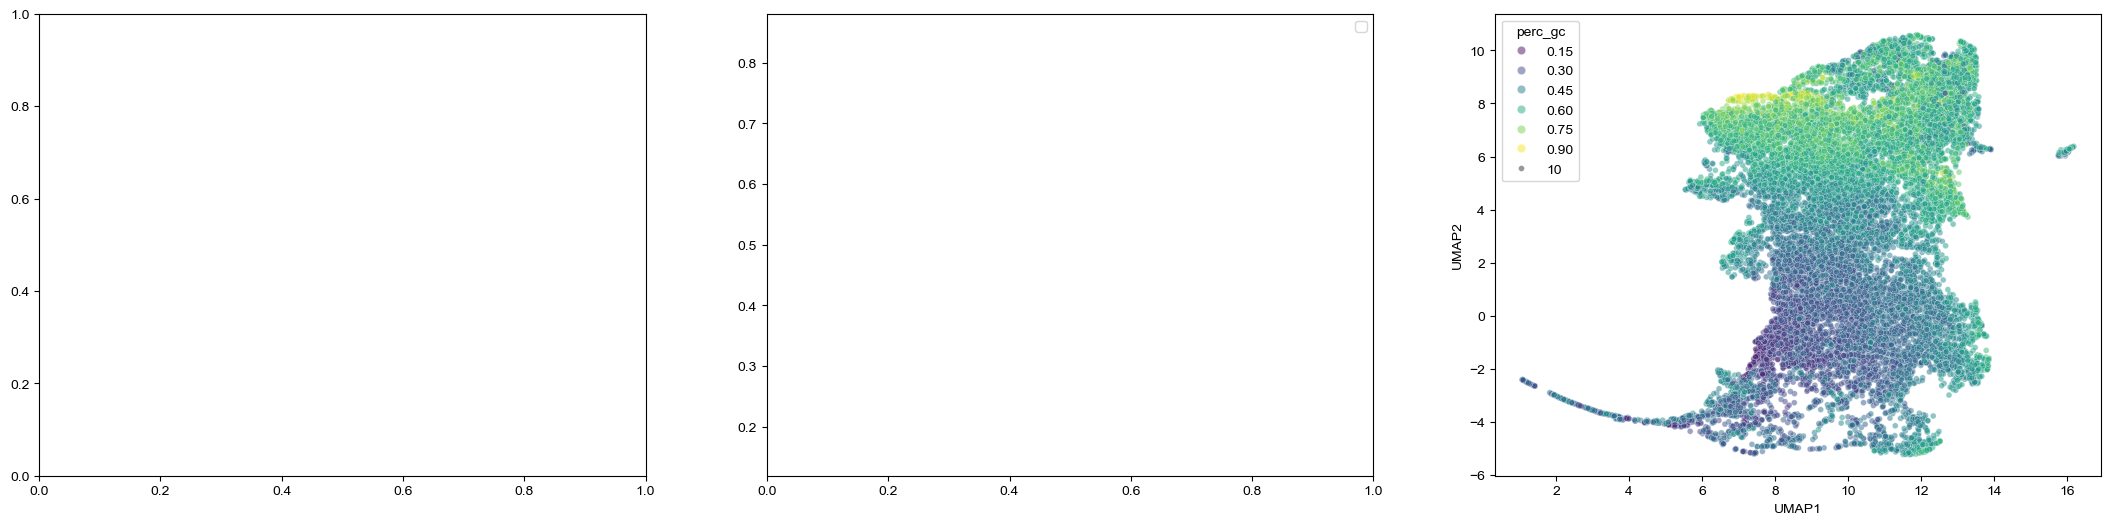

In [ ]:
fig = plt.figure(figsize=(36, 6))

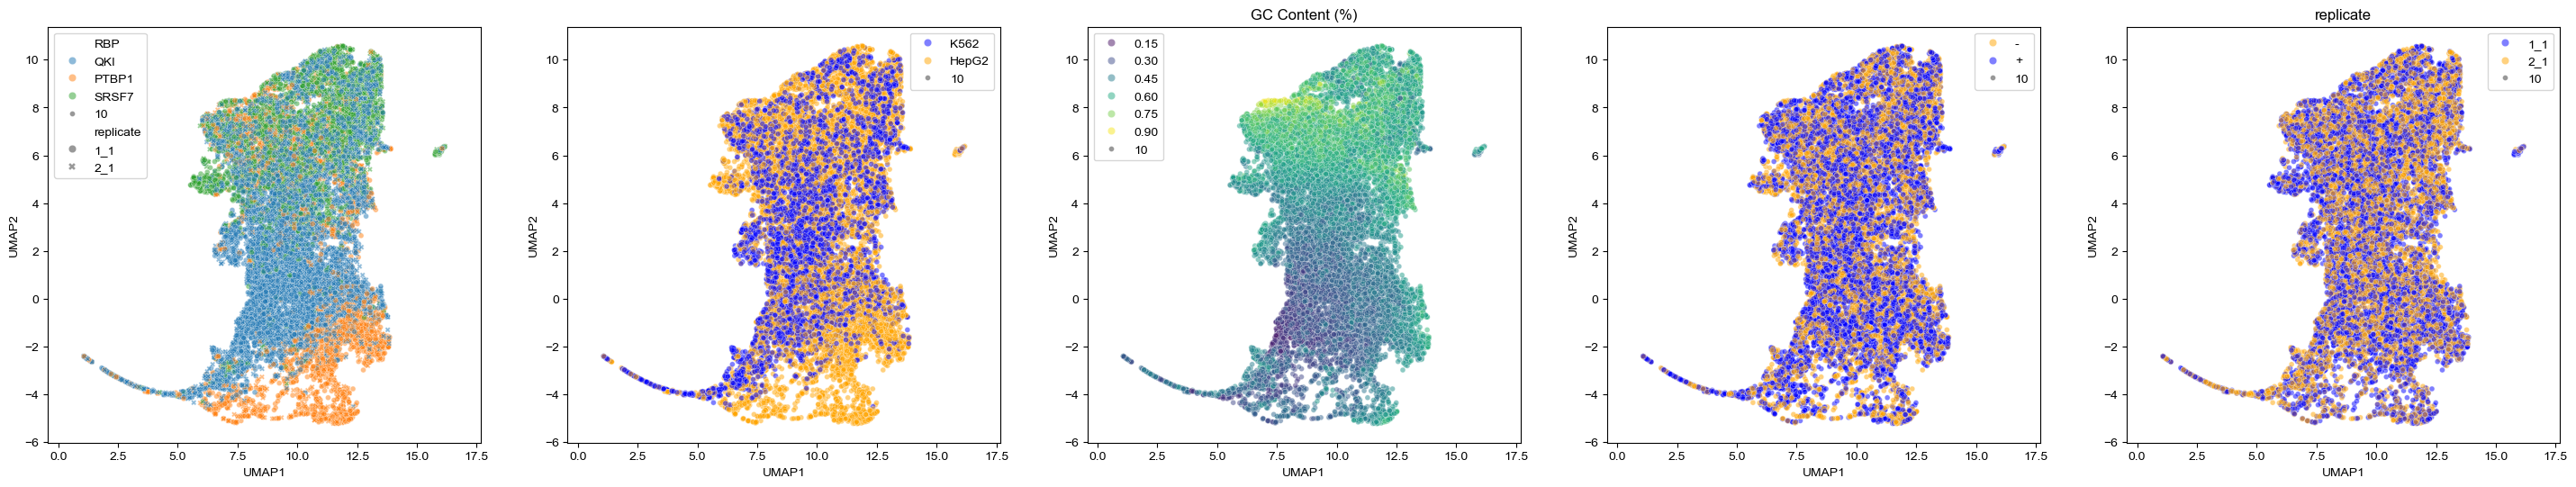

In [49]:
fig = plt.figure(figsize=(36, 6))

if params_source_peaks == "encore":
    total_cols = 5
else:
    total_cols = 4

ax1 = fig.add_subplot(1, total_cols, 1)
ax2 = fig.add_subplot(1, total_cols, 2)
ax3 = fig.add_subplot(1, total_cols, 3)
ax4 = fig.add_subplot(1, total_cols, 4)

if params_source_peaks == "encore":
    ax5 = fig.add_subplot(1, 5, 5)


# FIRST PLOT : COLOR BY RBP ;
sns.scatterplot(
    annotated_umap_results_df,
    x="UMAP1",
    y="UMAP2",
    hue="RBP",
    style="replicate" if params_source_peaks == "encore" else None,
    size=10,
    alpha=0.5,
    ax=ax1,
)
ax1.legend()
ax1.set_aspect("equal", adjustable="datalim")


# SECOND PLOT : COLOR BY CELL-LINE
sns.scatterplot(
    annotated_umap_results_df,
    x="UMAP1",
    y="UMAP2",
    hue="CL",
    size=10,
    palette={"K562": "blue", "HepG2": "orange"},
    alpha=0.5,
    ax=ax2,
)


ax2.legend()
ax2.set_aspect("equal", adjustable="datalim")
# ax2.set_title("Transcript Length (log10)")
#
#

# THIRD PLOT: : COLOR BY GC CONTENT
sns.scatterplot(
    annotated_umap_results_df,
    x="UMAP1",
    y="UMAP2",
    hue="perc_gc",
    size=10,
    palette="viridis",
    alpha=0.5,
    ax=ax3,
)

ax3.legend()
ax3.set_aspect("equal", adjustable="datalim")
ax3.set_title("GC Content (%)")
#

# FOURTH PLOT : COLOR BY STRAND
sns.scatterplot(
    annotated_umap_results_df,
    x="UMAP1",
    y="UMAP2",
    hue="strand",
    size=10,
    palette={"+": "blue", "-": "orange"},
    alpha=0.5,
    ax=ax4,
)


ax4.legend()
ax4.set_aspect("equal", adjustable="datalim")


if params_source_peaks == "encore":
    # FIFTH PLOT : COLOR BY REPLICATE

    sns.scatterplot(
        annotated_umap_results_df,
        x="UMAP1",
        y="UMAP2",
        hue="replicate",
        size=10,
        palette={"1_1": "blue", "2_1": "orange"},
        alpha=0.5,
        ax=ax5,
    )

    ax5.legend()
    ax5.set_aspect("equal", adjustable="datalim")
    ax5.set_title("replicate")

### Similarity of peaks through embeddings

Measuring the cosine similarity of two embeddings can provide insights into the similarity of the genomic regions they represent.

This can be particularly useful for comparing peaks from different RBPs or assessing the clustering of peaks based on their binding preferences.

TODO:

- Annotate extended regions on the presence of OTHER RBPs within the same genomic context 
- => Can we see that two RBPs sharing locations have similar embeddings? Relative to randomly paired peaks?